In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import holidays

import pmdarima as pm
from statsmodels.tsa.stattools import acf

from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams['figure.figsize'] = [16, 11]

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])
df = df[['data', 'nuovi_positivi']]
df['data'] = pd.to_datetime(df['data']).dt.normalize()
df = df.loc[(df['data'] >= '2021-03-01') & (df['data'] < '2023-05-01')]

x = df.groupby([pd.Grouper(key='data', freq='W-MON')])['nuovi_positivi'].sum()

df_italy = pd.DataFrame(x)

In [3]:
a = list(holidays.Italy(years=[2021, 2022, 2023]).keys())
hdays = []

for day in a:
    hdays.append(day)
    hdays.append((day-dt.timedelta(days=1)).strftime('%Y-%m-%d'))
    hdays.append((day-dt.timedelta(days=2)).strftime('%Y-%m-%d'))
    hdays.append((day-dt.timedelta(days=3)).strftime('%Y-%m-%d'))
    hdays.append((day-dt.timedelta(days=4)).strftime('%Y-%m-%d'))
    hdays.append((day-dt.timedelta(days=5)).strftime('%Y-%m-%d'))
    hdays.append((day-dt.timedelta(days=6)).strftime('%Y-%m-%d'))

In [4]:
is_holiday = [1 if x==True else 0 for x in [day in hdays for day in df_italy.index.strftime('%Y-%m-%d')]]

df_italy['holiday'] = is_holiday

In [66]:
results=pm.auto_arima(df_italy.nuovi_positivi, start_p=1, d=None, start_q=1, max_p=1, max_q=1,
                      seasonal=True, m=4, D=None, test='adf', start_P=0, start_Q=0, max_P=3, max_Q=3,
                      information_criterion='aic', trace=True, error_action='ignore',
                      trend=None, exog=df_italy['holiday'],with_intercept=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=2783.613, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2887.935, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2800.177, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=2798.374, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2885.940, Time=0.02 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=2779.374, Time=0.11 sec
 ARIMA(1,1,1)(2,0,0)[4] intercept   : AIC=2779.838, Time=0.17 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=2779.549, Time=0.18 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=2777.760, Time=0.11 sec
 ARIMA(1,1,1)(0,0,2)[4] intercept   : AIC=2779.537, Time=0.16 sec
 ARIMA(1,1,1)(1,0,2)[4] intercept   : AIC=2781.536, Time=0.38 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=2797.188, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=2867.986, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[4]             : AIC=2775.773, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[4]          

In [71]:
model=SARIMAX(df_italy.nuovi_positivi, order=(1, 1, 1), seasonal_order=(1, 0, 0, 4), exog = df_italy['holiday'])
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     nuovi_positivi   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 4)   Log Likelihood               -1389.033
Date:                            Sun, 10 Mar 2024   AIC                           2788.065
Time:                                    10:22:55   BIC                           2801.702
Sample:                                03-01-2021   HQIC                          2793.599
                                     - 05-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.035e+04   5595.671     -1.849      0.064   -2.13e+04     619.564
ar.L1          0.4816      0.083      5.788      0.000       0.319       0.645
ma.L1          0.5054      0.107      4.716      0.000       0.295       0.715
ar.S.L4       -0.2877      0.086     -3.337      0.001      -0.457      -0.119
sigma2      3.141e+09      0.109   2.87e+10      0.000    3.14e+09    3.14e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2409.79
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             2.94
Prob(H) (two-sided):                  0.92   Kurtosis:                        24.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+25. Standard errors may be unstable.
"""

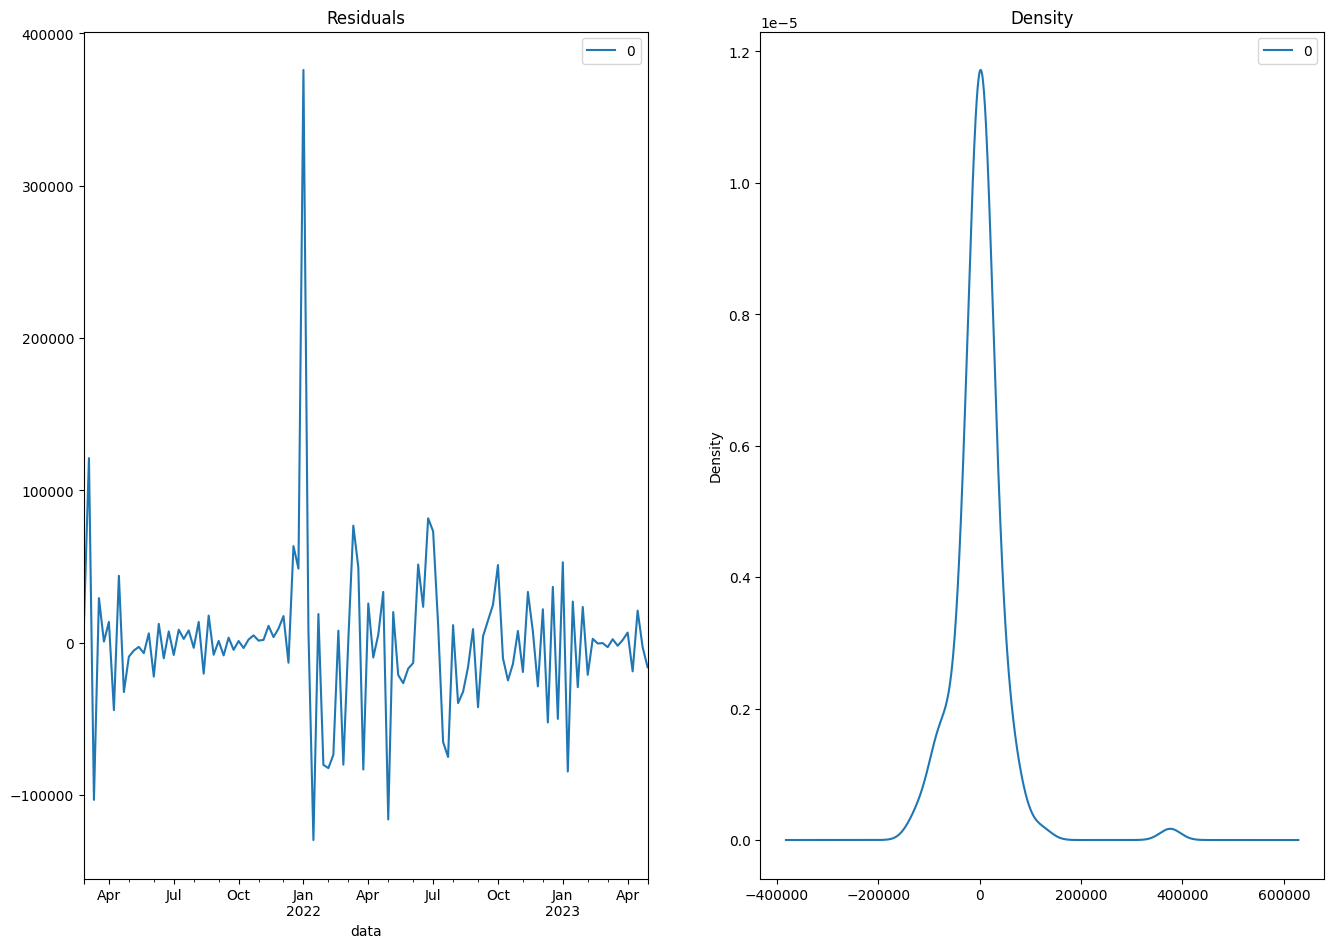

In [44]:
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

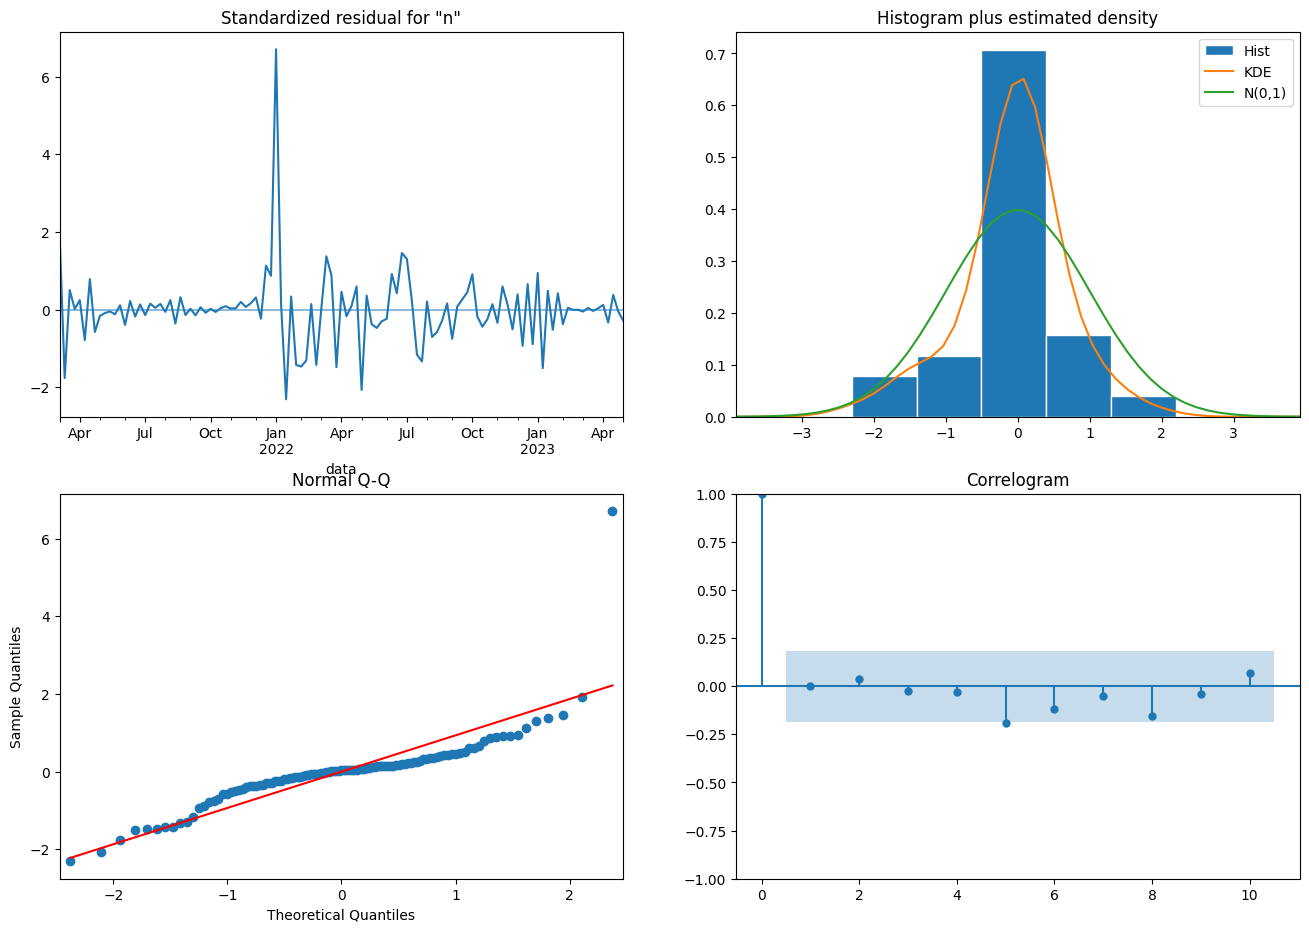

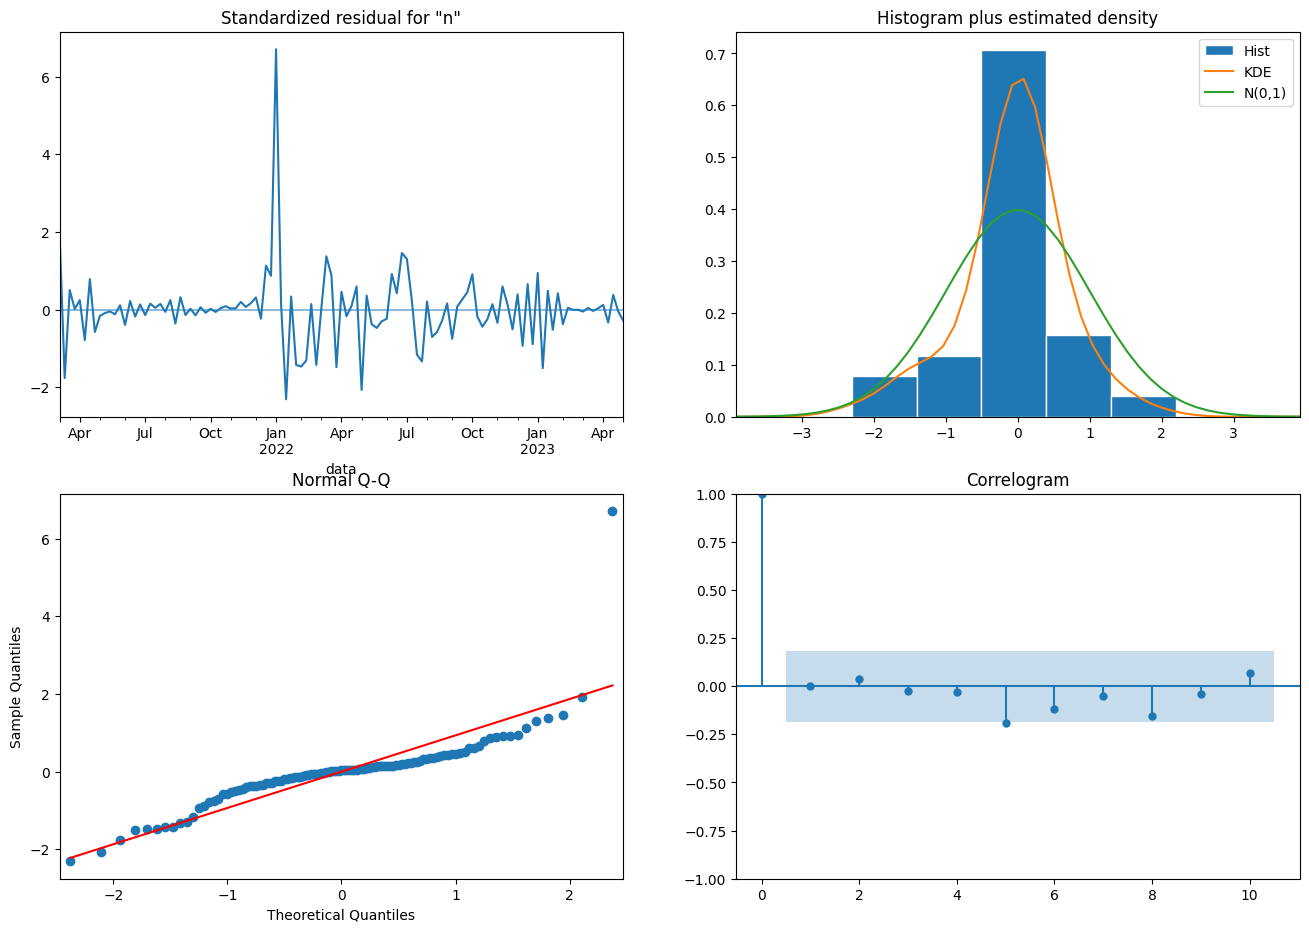

In [45]:
results.plot_diagnostics()

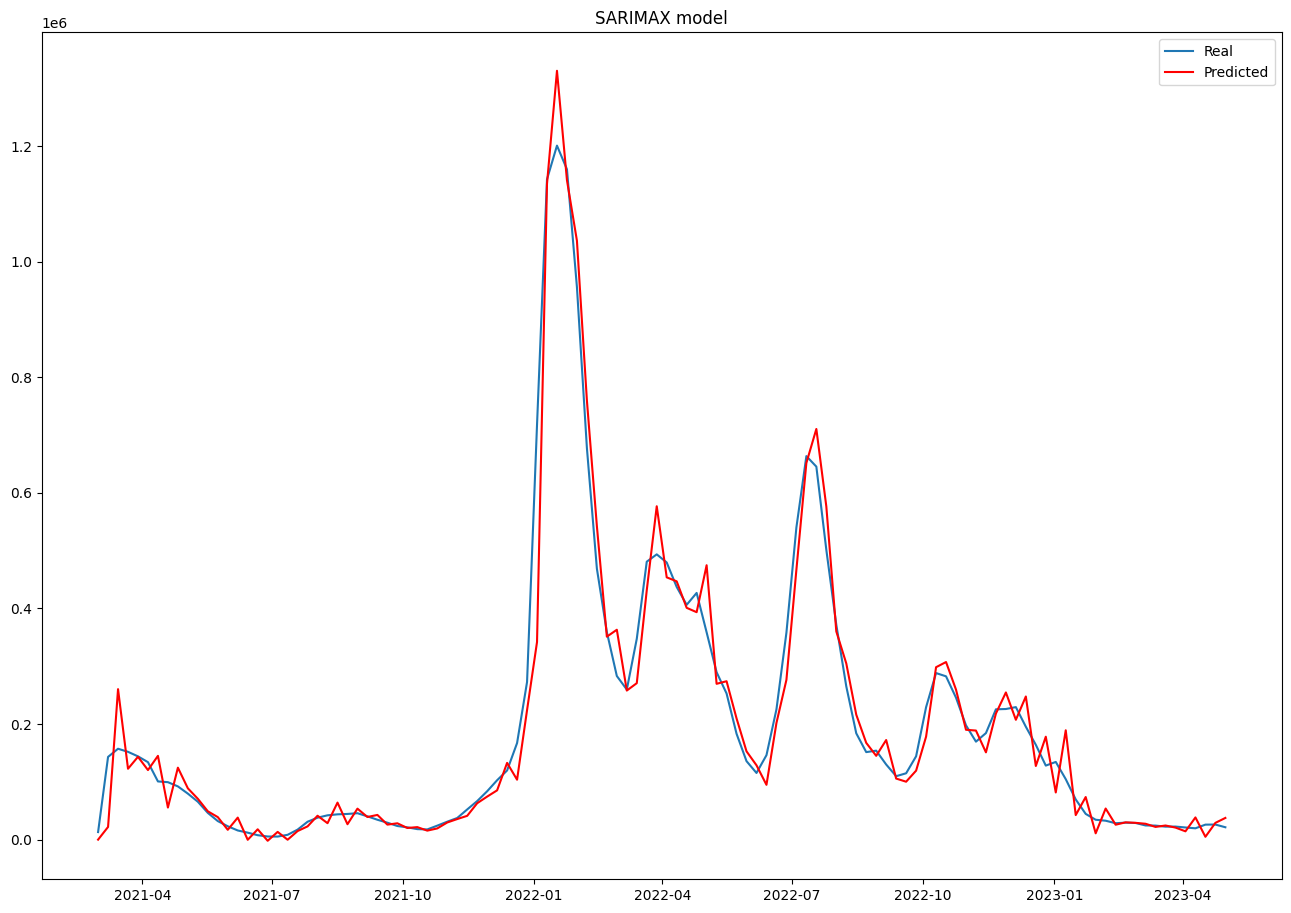

In [46]:
predictions = results.predict(dynamic=False)
plt.plot(df_italy.nuovi_positivi)
plt.plot(predictions, color='red')
plt.title('SARIMAX model')
plt.legend(['Real', 'Predicted'])
plt.show()

c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


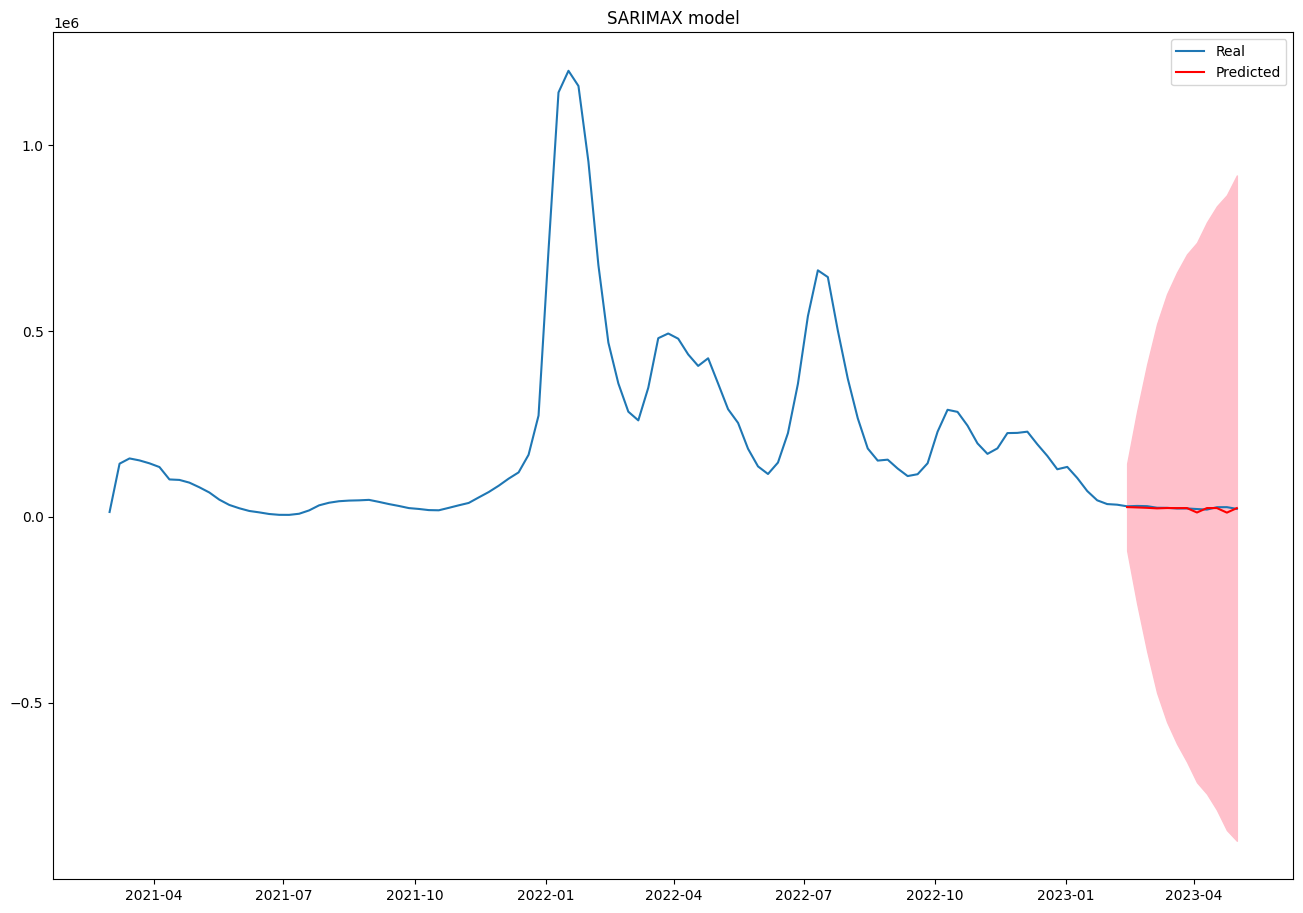

In [68]:
# Split dataset
train = df_italy[:int(0.9*len(df_italy))]
test = df_italy[int(0.9*len(df_italy)):]

# Model
model = SARIMAX(endog=train.nuovi_positivi, exog=train.holiday, order=(1, 1, 1), seasonal_order=(1, 0, 0, 4))
fitted = model.fit()

forecast_window = len(df_italy) - int(0.9*len(df_italy)) # forecasting window

forecast = fitted.get_forecast(steps=forecast_window, exog = df_italy['holiday'].iloc[-forecast_window:], alpha=0.05)
mean_forecast = forecast.predicted_mean

#Confidence Intervals for forecasting
confi_int_f = forecast.conf_int()
lower_limits_f = confi_int_f.iloc[:,0]
upper_limits_f = confi_int_f.iloc[:,1]
sarimax_forecast = pd.DataFrame({'yhat':mean_forecast, 'y_lower':lower_limits_f, 'y_upper':upper_limits_f})

plt.plot(df_italy.nuovi_positivi, label='Observed')
plt.plot(sarimax_forecast['yhat'], color='red', label='Predicted')
plt.fill_between(sarimax_forecast.index, sarimax_forecast['y_lower'], sarimax_forecast['y_upper'], color='pink')
plt.title('SARIMAX model')
plt.legend(['Real', 'Predicted'])
plt.show()

In [58]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]   # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 'acf1':acf1,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast metrics of: SARIMAX')
accuracy_prod = forecast_accuracy(mean_forecast.values, test.nuovi_positivi.values) #test.values.flatten())
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast metrics of: SARIMAX
mape :  0.1628
me :  -2582.9732
mae :  3963.1156
acf1 :  -0.3523
mpe :  -0.0964
rmse :  5607.3889
corr :  0.2527
minmax :  0.1588
